# Data preparation and cleaning
Before we work with the data and use it to train a model, we need to prepare it. This includes cleaning the data, transforming it into a format that is suitable for training a model, and splitting it into a training and test set. In this notebook, we will perform the following steps:
- Analyze the scraped dataset (class distribution)
- Use Canny edge detection to extract ROI from the images
- Crop the images to a fixed size including the ROI
- Perform data augmentation
- Construct datasets for training and testing

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import transform
import concurrent.futures as cf



In [14]:
gem_count = []
for gem in os.listdir('../dat/images'):
    count = len(os.listdir('../dat/images/' + gem))
    gem_count += [{'gem': gem, 'count': count}]
gem_count = pd.DataFrame(gem_count)
gem_count.sort_values(by='count', ascending=True, inplace=True)
number_of_images = gem_count['count'].sum()

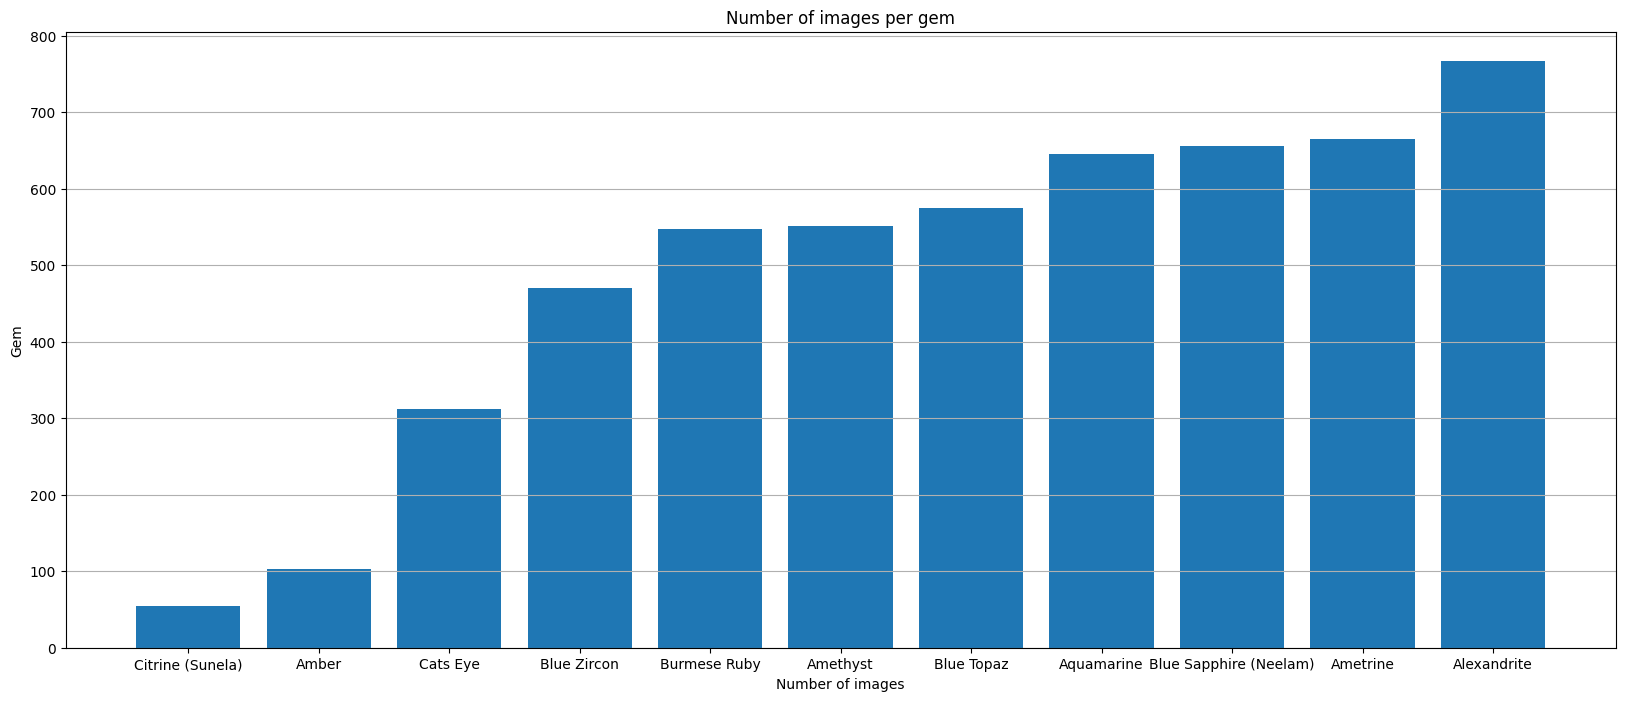

In [15]:
plt.figure(figsize=(20, 8))
plt.bar(gem_count['gem'], gem_count['count'])
plt.title('Number of images per gem')
plt.xlabel('Number of images')
plt.ylabel('Gem')
plt.grid(axis='y')
plt.show()

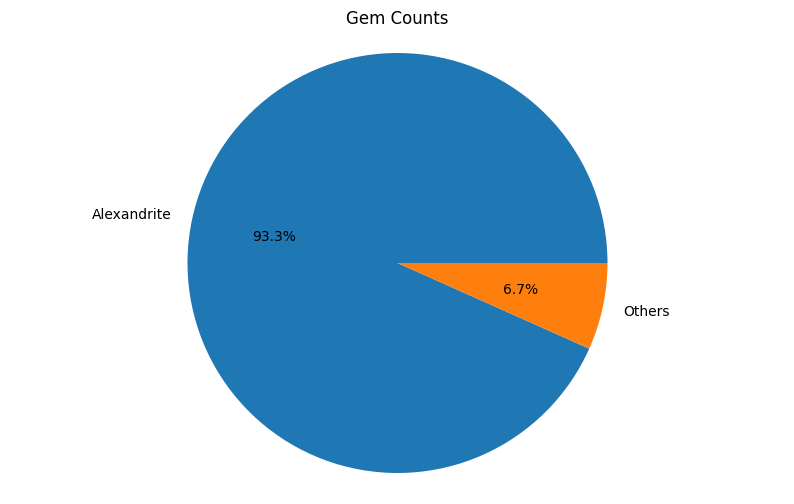

In [16]:
number_of_classes = 2

top = gem_count.tail(number_of_classes-1)
others_count = gem_count.iloc[:number_of_classes-1]['count'].sum()
others_row = pd.DataFrame({'gem': ['Others'], 'count': [others_count]})
df = pd.concat([top, others_row], ignore_index=True)

plt.figure(figsize=(10,  6))  # Optional: set the figure size
plt.pie(df['count'], labels=df['gem'], autopct='%1.1f%%')
plt.title('Gem Counts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

We can see that the distribution of the classes is not balanced.
X classes make up for 2/3 of the total images, while the remaining 1/3 is distributed among the other X of classes.

This is a common problem in machine learning and can lead to a biased model. We will address this issue by using data augmentation to create additional training samples for the minority classes.

### Crop images using Canny edge detection

To extract the region of interest (ROI) from the images, we will use the Canny edge detection algorithm.
This ensures that the model focuses on the relevant part of the image and ignores the background.

The image is then cropped to a fixed size, including the ROI.
By doing this, we can ensure that the model receives consistent input data with maximum relevant information.

In [3]:
def edge_and_cut(img):
    try:
        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #blur = cv2.GaussianBlur(gray, (2,2), 0)
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            # crop the region but let it be a square
            if (y2-y1)>(x2-x1):
                x1 = x1-(y2-y1-x2+x1)//2
                x2 = x2+(y2-y1-x2+x1)//2
            else:
                y1 = y1-(x2-x1-y2+y1)//2
                y2 = y2+(x2-x1-y2+y1)//2

            new_img = img[y1:y2, x1:x2]             

            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
            
        else:
            new_img = cv2.resize(img,(img_w, img_h))

    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [4]:
def show_cropped(img):
    emb_img = img.copy()

    edges = cv2.Canny(emb_img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)
        # crop the region but let it be a square
        if (y2-y1)>(x2-x1):
            x1 = x1-(y2-y1-x2+x1)//2
            x2 = x2+(y2-y1-x2+x1)//2
        else:
            y1 = y1-(x2-x1-y2+y1)//2
            y2 = y2+(x2-x1-y2+y1)//2

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        #return new_img
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)
    plt.show()

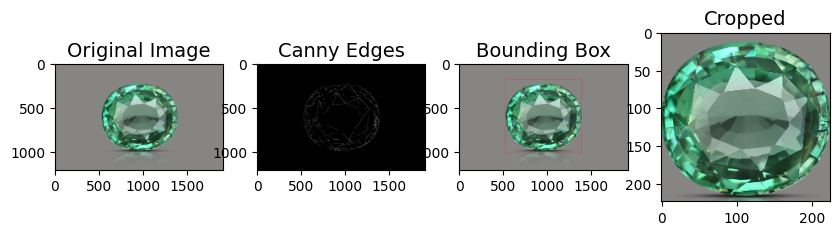

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [6]:
img_w, img_h = 224, 224

img = cv2.imread('../dat\images\Alexandrite\gp96288-1-060522.jpg.jpg')
show_cropped(img)


executor = cf.ThreadPoolExecutor(max_workers=8)

for gem in os.listdir('../dat/images'):
    out_folder = os.path.join('../dat/images_cropped/', gem)
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    def process_image(img):
        image = cv2.imread(os.path.join('../dat/images/', gem, img))
        image = edge_and_cut(image)
        cv2.imwrite(os.path.join(out_folder, img), image)

    futures = [executor.submit(process_image, img) for img in os.listdir('../dat/images/' + gem)]
    cf.wait(futures)

    # for img in os.listdir('../dat/images/' + gem):
    #     image = cv2.imread(os.path.join('../dat/images/', gem, img))
    #     image = edge_and_cut(image)
    #     cv2.imwrite(os.path.join(out_folder, img), image)

### Perform image augmentation

In [ ]:
def transform_images(src, goal):
    for root, dirs, files in os.walk(src):
        dst = root.replace('images', 'images_augmented')
        os.makedirs(dst, exist_ok=True)
        
        flip = False
        size = len(files)
        num_to_edit = np.ceil((goal-size) / 3).astype(int)
        if num_to_edit > size:
            flip = True
            num_to_edit = np.ceil((goal-size) / 7).astype(int)
        print(root, max(0, min(num_to_edit, size)))
        for file in np.random.choice(files, max(0, min(num_to_edit, size)), replace=False):
            try:
                image = cv2.imread(os.path.join(root, file))
                if flip:
                    plt.imsave(os.path.join(dst, file[:-4]+'_flip'+file[-4:]), np.fliplr(image))
                    plt.imsave(os.path.join(dst, file[:-4]+'_flip'+file[-4:]), np.flipud(image))
                # apply different rotations
                for angle in rotations:
                    # save image
                    rot_img = transform.rotate(image, angle=angle)
                    plt.imsave(os.path.join(dst, file[:-4]+'_rot'+str(angle)+file[-4:]), rot_img)
                    if flip:
                        plt.imsave(os.path.join(dst, file[:-4]+'_'+str(angle)+'_fliplr'+file[-4:]), np.fliplr(rot_img))
                        plt.imsave(os.path.join(dst, file[:-4]+'_'+str(angle)+'_flipud'+file[-4:]), np.flipud(rot_img))
            except:
                pass

In [ ]:
rotations = [90, 180, 270]
goal = 2000
transform_images(src='../dat/images_cropped/', goal=goal)

../dat/images/ 0
../dat/images/Alexandrite 411
